In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=pd.core.generic.SettingWithCopyWarning)

In [2]:
data=pd.read_csv("coursework_data.csv")
data.head()

,Call_Date
0,01/03/2019 00:15:39
1,01/03/2019 00:59:44
2,01/03/2019 01:15:00
3,01/03/2019 01:40:40
4,01/03/2019 01:49:28


In [3]:
data['Call_Date'] = pd.to_datetime(data['Call_Date'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32905 entries, 0 to 32904
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Call_Date  32905 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 257.2 KB


In [5]:
data['Dates'] = data['Call_Date'].dt.strftime('%d-%m-%Y') #extracting the dates

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32905 entries, 0 to 32904
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Call_Date  32905 non-null  datetime64[ns]
 1   Dates      32905 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 514.3+ KB


In [7]:
df = data['Dates'].value_counts().reset_index()
df.columns = ['Dates', 'Calls']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Dates   214 non-null    object
 1   Calls   214 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ KB


In [9]:
df.head()

,Dates,Calls
0,31-07-2019,240
1,17-07-2019,210
2,08-05-2019,209
3,09-11-2019,208
4,27-08-2019,208


In [10]:
dfn=df.copy()

In [11]:
dfn['Dates'] = pd.to_datetime(dfn['Dates'])
df_sorted = dfn.sort_values(by='Dates')
df_sorted['Dates'] = df_sorted['Dates'].dt.strftime('%d-%m-%Y')

C:\Users\Rutvik\AppData\Local\Temp\ipykernel_11428\1710564041.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dfn['Dates'] = pd.to_datetime(dfn['Dates'])


In [12]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 129 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Dates   214 non-null    object
 1   Calls   214 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ KB


In [13]:
df_sorted.head()

,Dates,Calls
129,01-03-2019,148
179,02-03-2019,110
146,03-03-2019,132
31,04-03-2019,193
61,05-03-2019,181


In [14]:
df_sorted['Dates'] = pd.to_datetime(df_sorted['Dates'],dayfirst=True, format='%d-%m-%Y')

In [15]:
df_sorted.head() #dataset in the ascending order of the dates

,Dates,Calls
129,2019-03-01,148
179,2019-03-02,110
146,2019-03-03,132
31,2019-03-04,193
61,2019-03-05,181


In [16]:
#taking a look at the public holidays in Indonesia from March 2019 to September 2019 and comparing them with the calls in hope of finding an insight

holidays = {
    'New Year\'s Day': '2019-01-01',
    'Chinese New Year': '2019-02-05',
    'Bali\'s Day of Silence': '2019-03-07',
    'Good Friday': '2019-04-19',
    'Labor Day': '2019-05-01',
    'Ascension of Jesus Christ': '2019-05-30',
    'Waisak Day': '2019-05-19',
    'Idul Fitri': ['2019-06-05', '2019-06-06'],
    'Independence Day': '2019-08-17',
    'Islamic New Year': '2019-08-31',
    'Idul Adha': '2019-08-11',
    'Muharram': '2019-09-10',
    'Prophet Muhammad\'s Birthday': '2019-11-09',
    'Christmas Day': '2019-12-25'
}

df_holidays = pd.DataFrame(list(holidays.items()), columns=['Holiday', 'Date'])
df_holidays = df_holidays.explode('Date')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])

In [17]:
df_holidays

,Holiday,Date
0,New Year's Day,2019-01-01
1,Chinese New Year,2019-02-05
2,Bali's Day of Silence,2019-03-07
3,Good Friday,2019-04-19
4,Labor Day,2019-05-01
5,Ascension of Jesus Christ,2019-05-30
6,Waisak Day,2019-05-19
7,Idul Fitri,2019-06-05
7,Idul Fitri,2019-06-06
8,Independence Day,2019-08-17


In [18]:
new_df=df_sorted.copy()

In [19]:
new_df.set_index('Dates', inplace=True)

In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214 entries, 2019-03-01 to 2019-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Calls   214 non-null    int64
dtypes: int64(1)
memory usage: 3.3 KB


In [21]:
print("Length of index:", len(new_df.index))
print("Length of data column:", len(new_df['Calls']))

Length of index: 214
Length of data column: 214


In [22]:
date_range_span = new_df.index.max() - new_df.index.min()
print("Date range span:", date_range_span)

Date range span: 213 days 00:00:00


In [23]:
dfa=new_df.copy()

In [24]:
#numerical summary

col = dfa['Calls']
summary = {
    'Min': col.min(),
    'Max': col.max(),
    'Median': col.median(),
    'Mean' : col.mean(),
    'IQR': col.quantile(0.75) - col.quantile(0.25),
    'Variance': col.var(),
    'Standard Deviation': col.std()
}

summary_df = pd.DataFrame(summary, index=[1])
summary_df

,Min,Max,Median,Mean,IQR,Variance,Standard Deviation
1,60,240,163.5,153.761682,64.5,1400.266882,37.42014


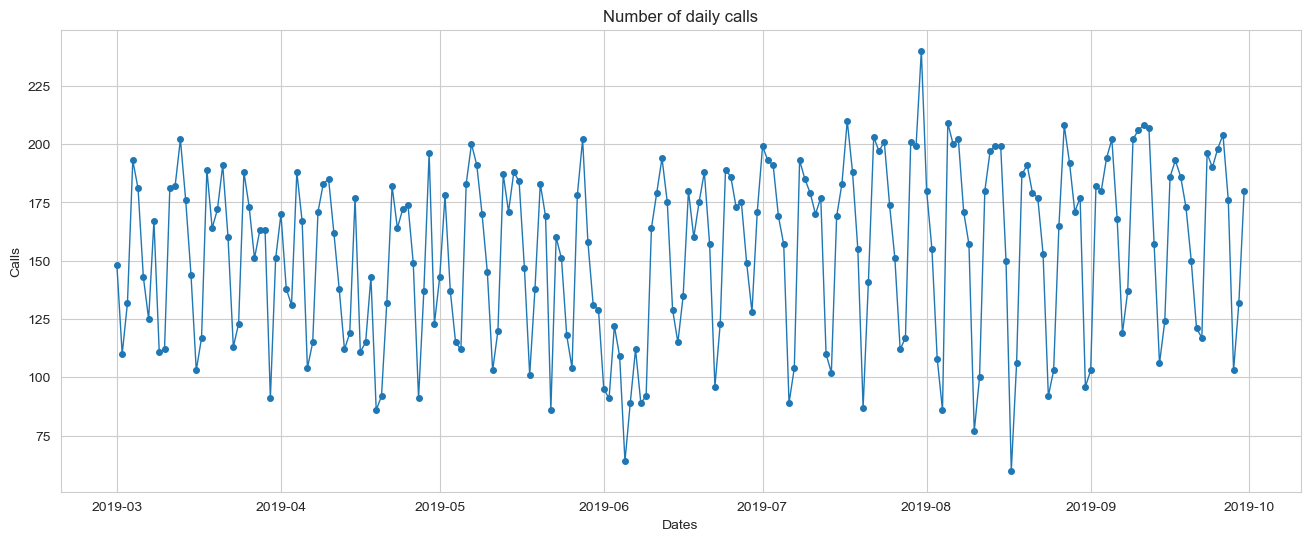

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
plt.ylabel('Calls')
plt.xlabel('Dates')
plt.title('Number of daily calls')
plt.plot(new_df.index, new_df['Calls'],lw=1, marker='o', markersize=4)
plt.show()

In [27]:
merged_df = new_df.merge(df_holidays, how='left', left_index=True, right_on='Date')
merged_df['Holiday'].fillna('', inplace=True)

In [28]:
merged_df.set_index('Date', inplace=True)

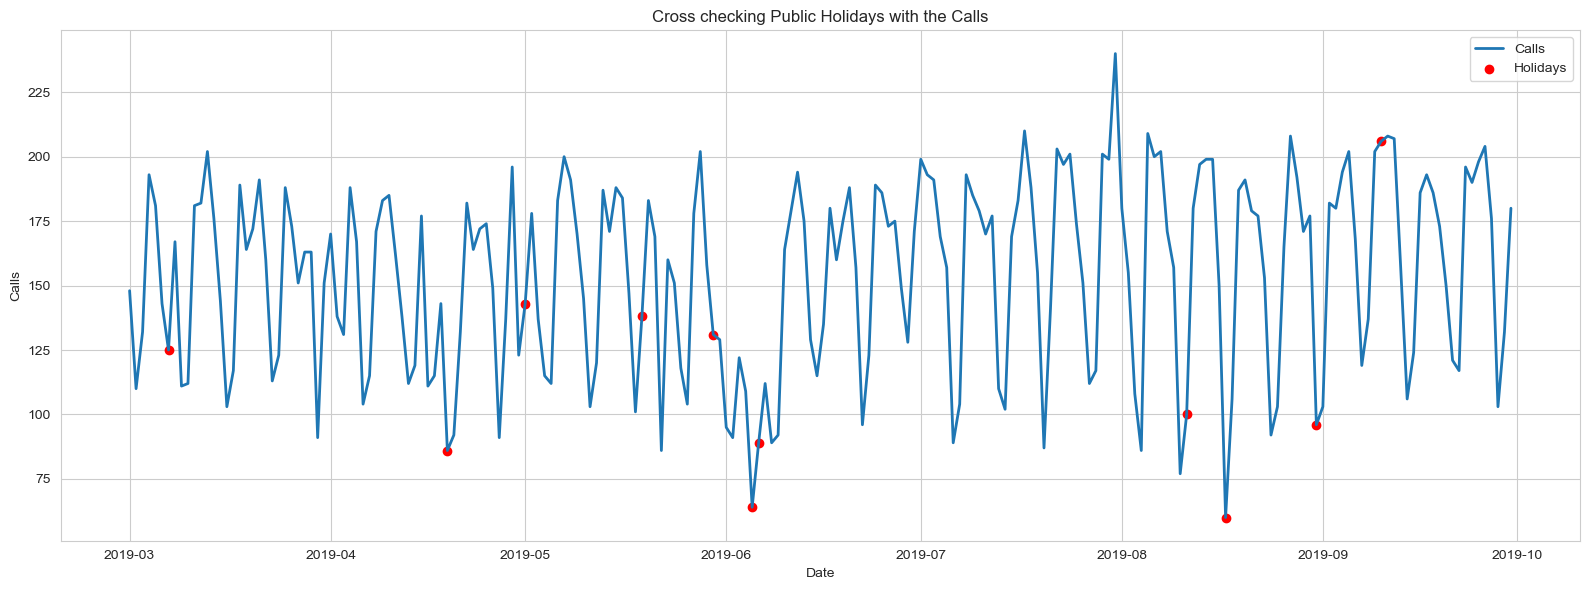

In [78]:
plt.figure(figsize=(16, 6))
plt.plot(merged_df.index, merged_df['Calls'], label='Calls', lw=2)
plt.scatter(merged_df[merged_df['Holiday'] != ''].index, merged_df[merged_df['Holiday'] != '']['Calls'], color='red', label='Holidays')
plt.title('Cross checking Public Holidays with the Calls')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
dfa['weekday'] = dfa.index.day_name() #extracting the names of the days in the week

In [31]:
dfa.head()

,Calls,weekday
Dates,,
2019-03-01,148,Friday
2019-03-02,110,Saturday
2019-03-03,132,Sunday
2019-03-04,193,Monday
2019-03-05,181,Tuesday


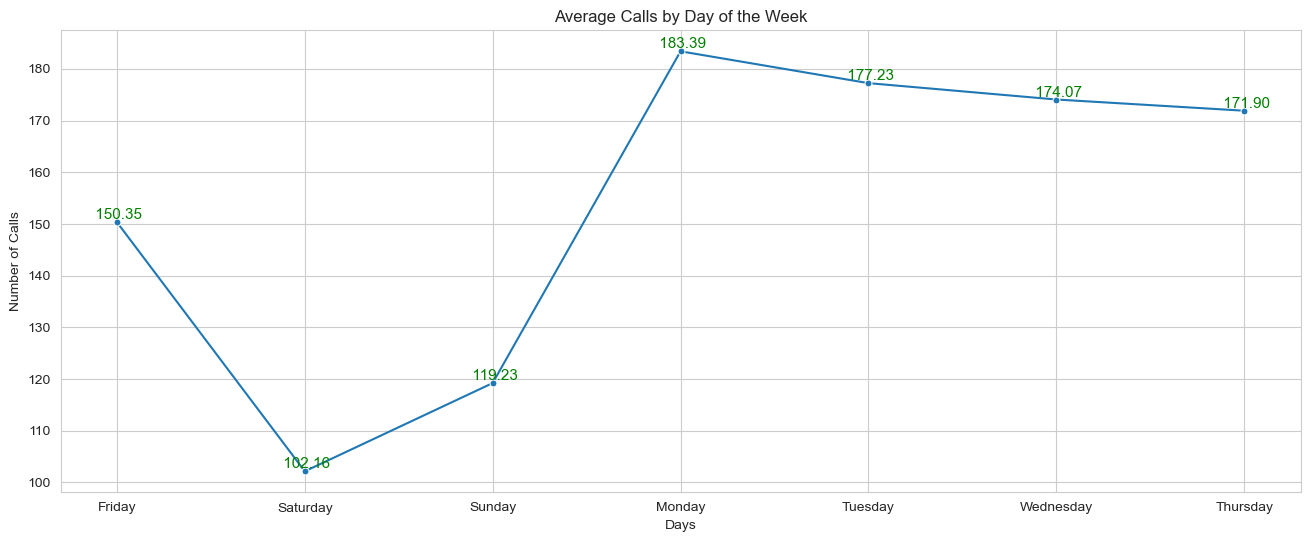

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
sns.lineplot(data=dfa, x='weekday', y='Calls', estimator='mean', errorbar=None, marker='o',markersize=5)
avg_calls_per_day = dfa.groupby('weekday')['Calls'].mean()
for weekday, avg_calls in avg_calls_per_day.items():
    plt.text(weekday, avg_calls, f" {avg_calls:.2f}", ha='center', va='bottom', color='green',fontsize=11)
plt.title('Average Calls by Day of the Week')
plt.xlabel('Days')
plt.ylabel('Number of Calls')
plt.show()

In [33]:
dfa['month'] = dfa.index.month_name() #extracting the names of the months

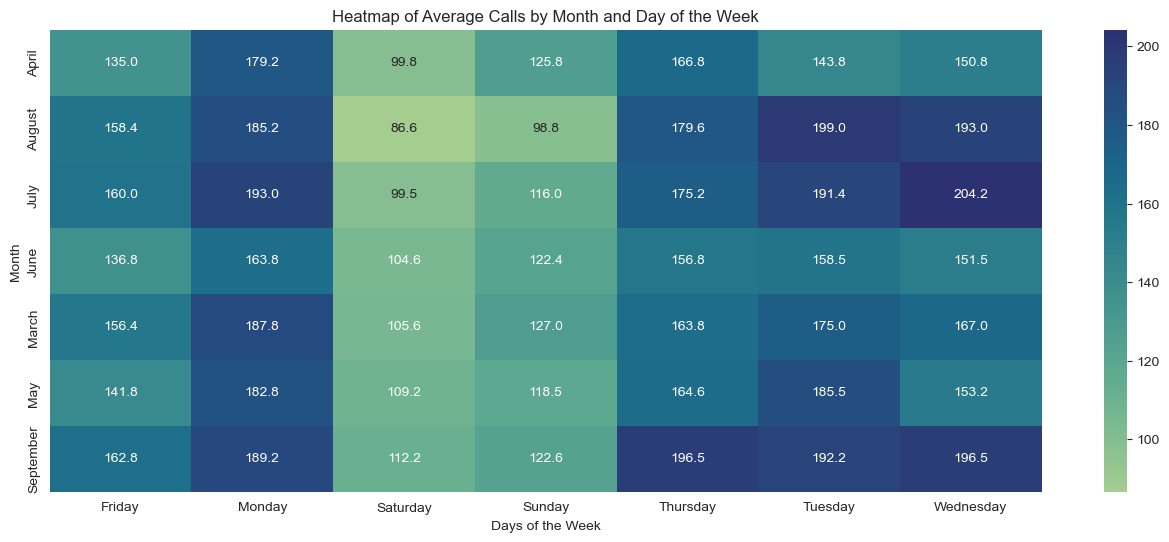

In [34]:
df_pivot = dfa.pivot_table(index='month', columns='weekday', values='Calls', aggfunc='mean')
plt.figure(figsize=(16, 6))
sns.heatmap(df_pivot, cmap='crest', annot=True, fmt=".1f")
plt.title('Heatmap of Average Calls by Month and Day of the Week')
plt.xlabel('Days of the Week')
plt.ylabel('Month')
plt.show()

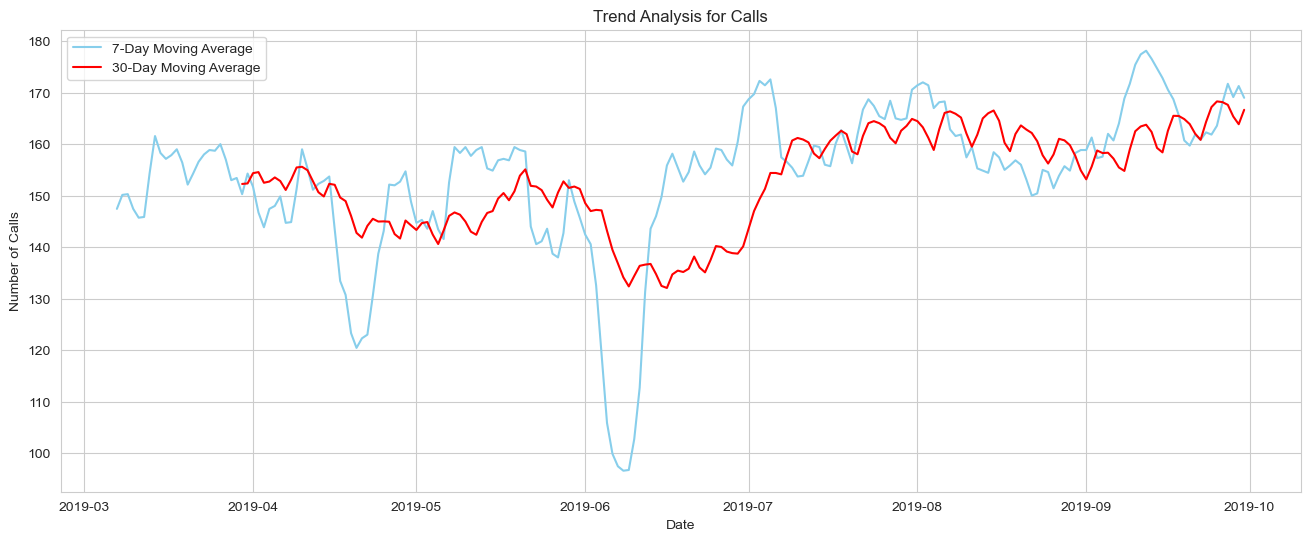

In [35]:
rolling_mean2 = dfa['Calls'].rolling(window=7).mean()
rolling_mean3 = dfa['Calls'].rolling(window=30).mean()
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
plt.plot(rolling_mean2.index, rolling_mean2, label='7-Day Moving Average', color='skyblue')
plt.plot(rolling_mean3.index, rolling_mean3, label='30-Day Moving Average', color='red')
plt.title('Trend Analysis for Calls')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.grid(True)
plt.show()

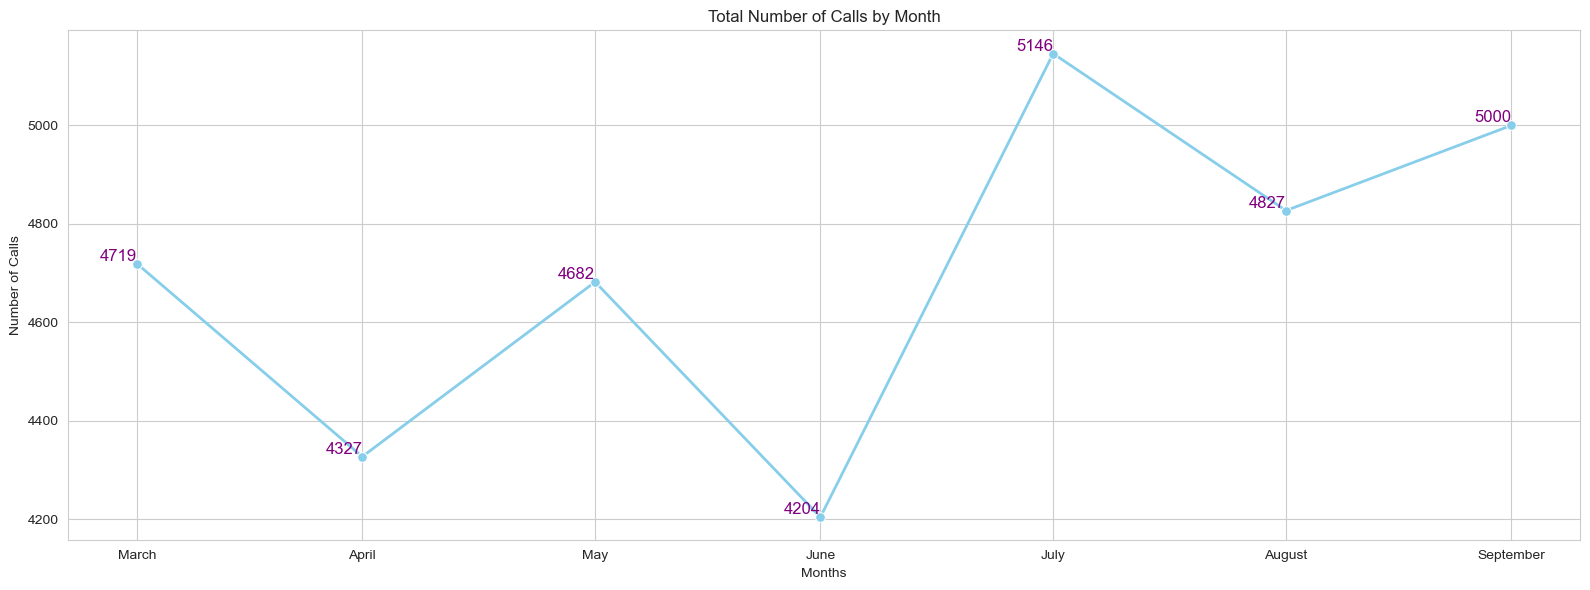

In [36]:
total_m = dfa.resample('M')['Calls'].sum()
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
sns.lineplot(data=total_m, marker='o', color='skyblue',lw=2, markersize=7)

for date, calls in total_m.items():
    month_name = date.strftime('%B')  # for extracting names of the month
    plt.text(date, calls, f"{calls}", ha='right', va='bottom', color='purple', fontsize=12)  

plt.xticks(ticks=total_m.index, labels=total_m.index.strftime('%B'))
plt.title('Total Number of Calls by Month')
plt.xlabel('Months')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
df2=dfa.copy()

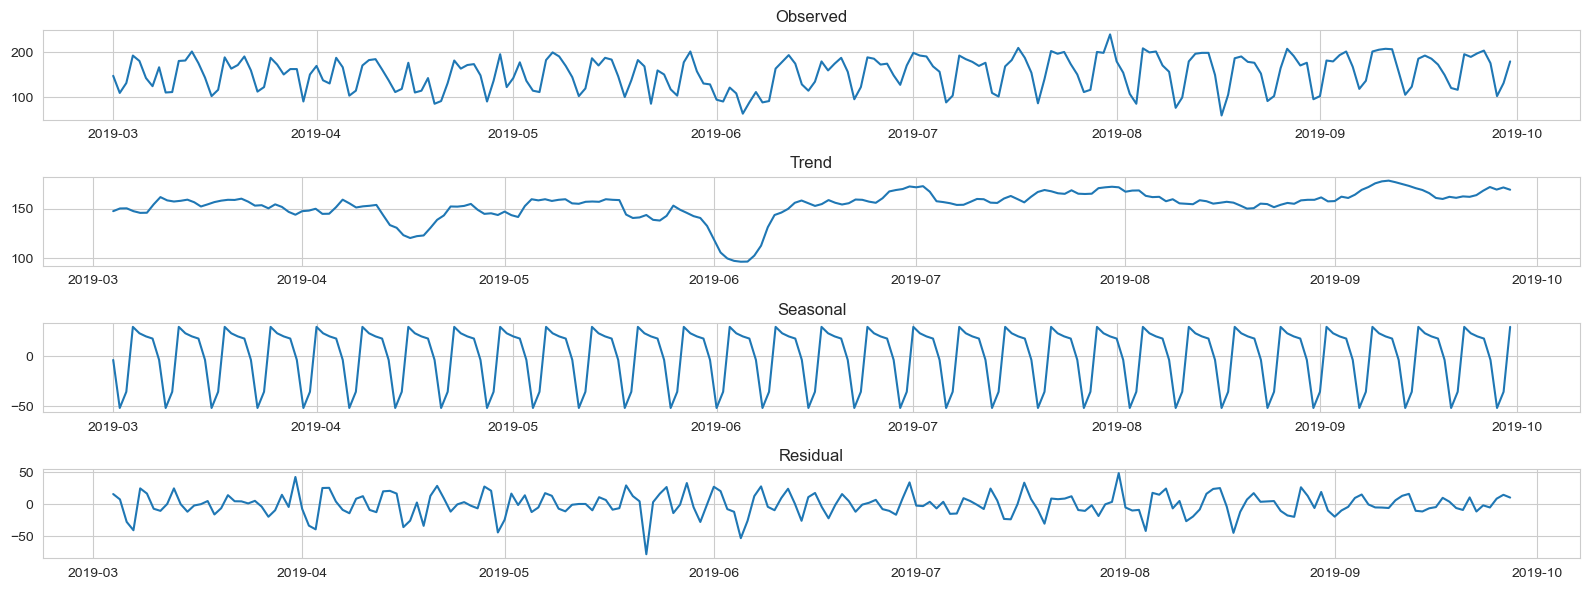

In [38]:
#seasonal decompositon by additive model
result = seasonal_decompose(df2['Calls'], model='add',period=7)
plt.figure(figsize=(16, 6))

plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonal')

plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

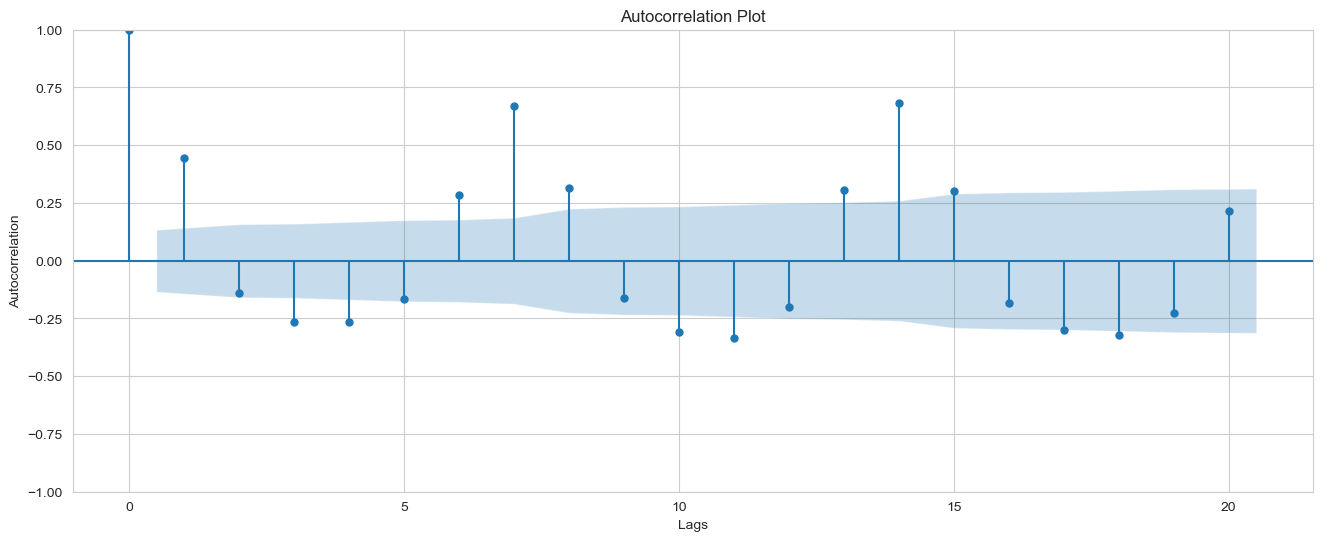

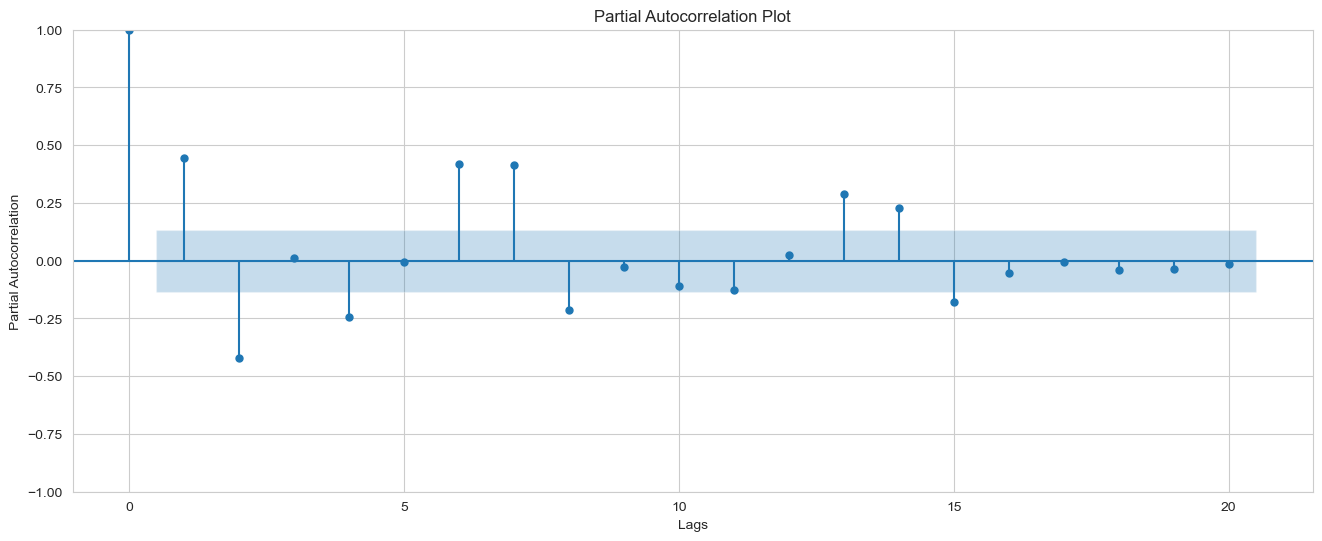

In [40]:
# Autocorrelation
plt.figure(figsize=(16, 6))
plot_acf(df2['Calls'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Partial autocorrelation
plt.figure(figsize=(16, 6))
plot_pacf(df2['Calls'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Plot')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [41]:
df2=df2.drop(columns=['weekday','month'])

In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214 entries, 2019-03-01 to 2019-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Calls   214 non-null    int64
dtypes: int64(1)
memory usage: 3.3 KB


In [43]:
resamp_df = df2.resample('D').sum() #resampling with daily frequency

In [44]:
new_df1=resamp_df.copy()

In [45]:
resamp_df.head()

,Calls
Dates,
2019-03-01,148
2019-03-02,110
2019-03-03,132
2019-03-04,193
2019-03-05,181


In [46]:
train_size = int(len(resamp_df) * 0.8)  # splitting the datset into training and testing sets 80% for training, 20% for testing
train, test = resamp_df.iloc[:train_size], resamp_df.iloc[train_size:]

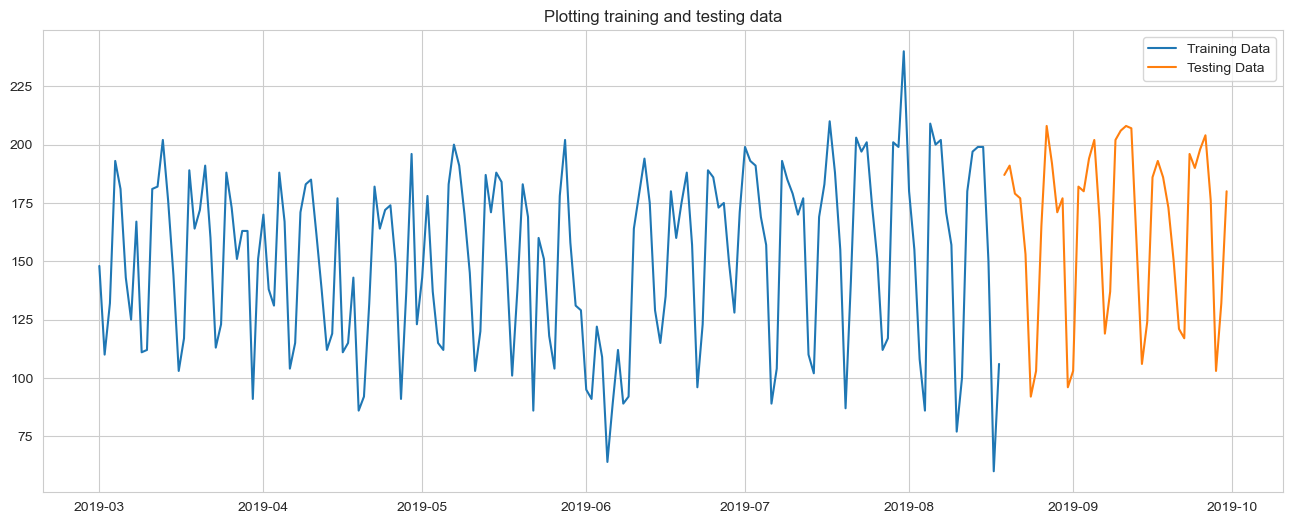

In [47]:
# Plotting the training and testing sets
plt.figure(figsize=(16, 6))
plt.title('Plotting training and testing data')
plt.plot(train.index, train['Calls'], label='Training Data')
plt.plot(test.index, test['Calls'], label='Testing Data')
plt.legend()
plt.show()

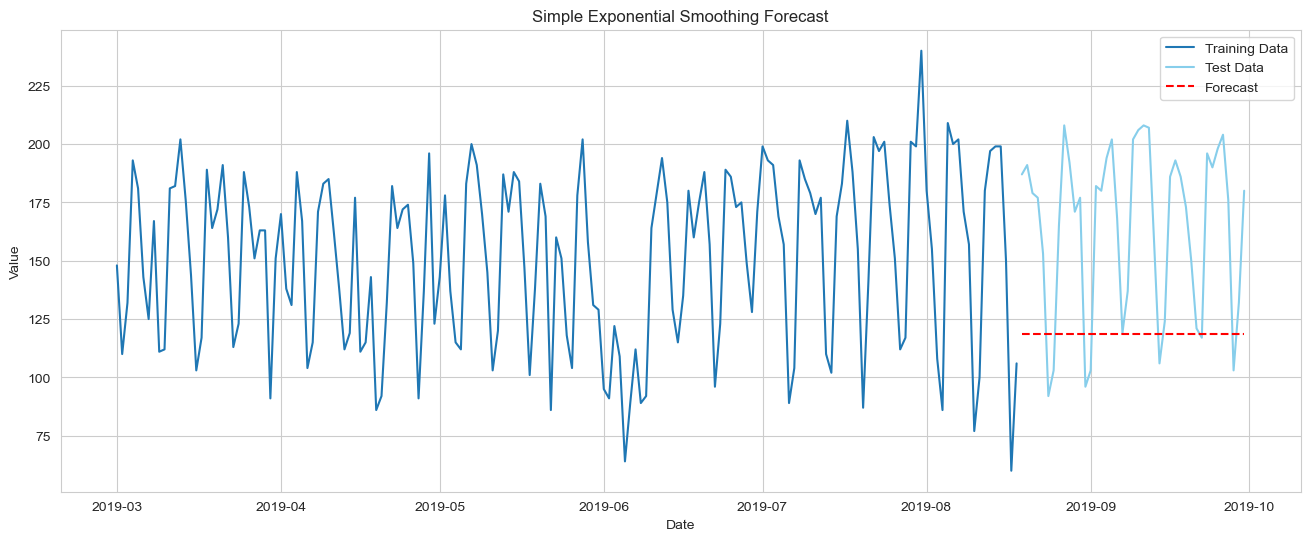

In [48]:
alpha = 0.4
model_simp = SimpleExpSmoothing(train['Calls'], initialization_method='heuristic')
fit_model = model_simp.fit(smoothing_level=alpha,optimized=False)
forecast_simp = fit_model.forecast(len(test))

plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Calls'], label='Training Data')
plt.plot(test.index, test['Calls'], label='Test Data', color='skyblue')
plt.plot(test.index, forecast_simp, label='Forecast', color='red', linestyle='--')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
def naive_fore(train, test):
    prev_val = train.iloc[-1]
    forecast = [prev_val] * len(test)
    return forecast

naive_pred = naive_fore(train['Calls'], test['Calls'])

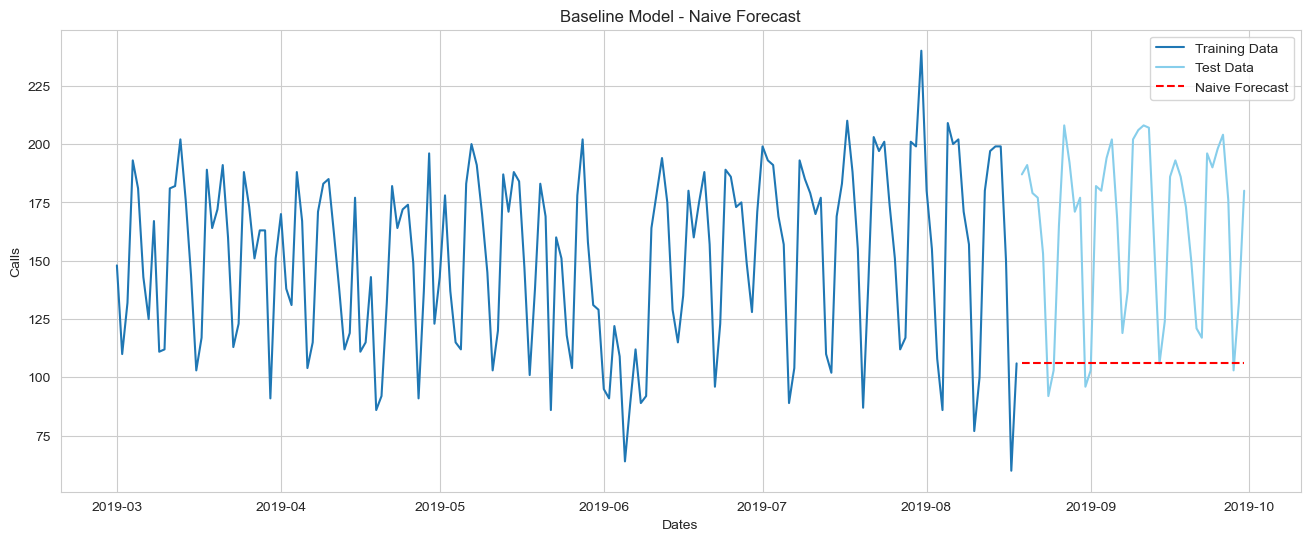

In [50]:
plt.figure(figsize=(16, 6))
plt.plot(train['Calls'], label='Training Data')
plt.plot(test['Calls'], label='Test Data', color='skyblue')
plt.plot(test.index, naive_pred, label='Naive Forecast', linestyle='--', color='red')
plt.title('Baseline Model - Naive Forecast')
plt.xlabel('Dates')
plt.ylabel('Calls')
plt.legend()
plt.grid(True)
plt.show()

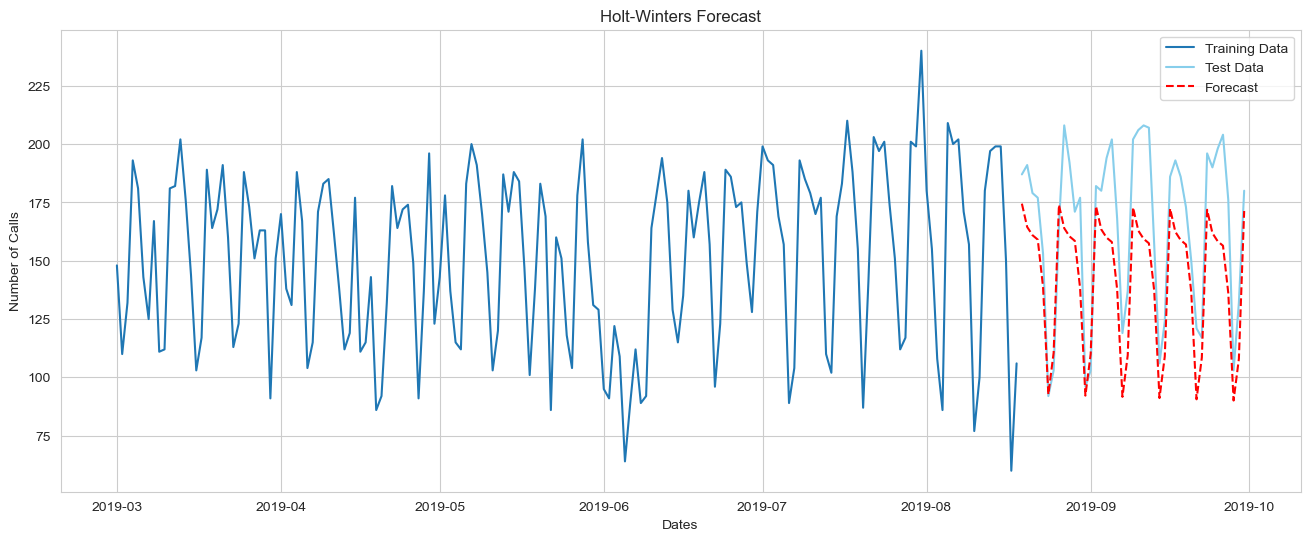

In [51]:
model1 = ExponentialSmoothing(train['Calls'],trend='add',seasonal='add', seasonal_periods=7)  
fit_model1 = model1.fit()
forecast_exp = fit_model1.forecast(len(test))

plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Calls'], label='Training Data')
plt.plot(test.index, test['Calls'], label='Test Data', color='skyblue')
plt.plot(test.index, forecast_exp, label='Forecast', color='red', linestyle='--')
plt.title('Holt-Winters Forecast')
plt.xlabel('Dates')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

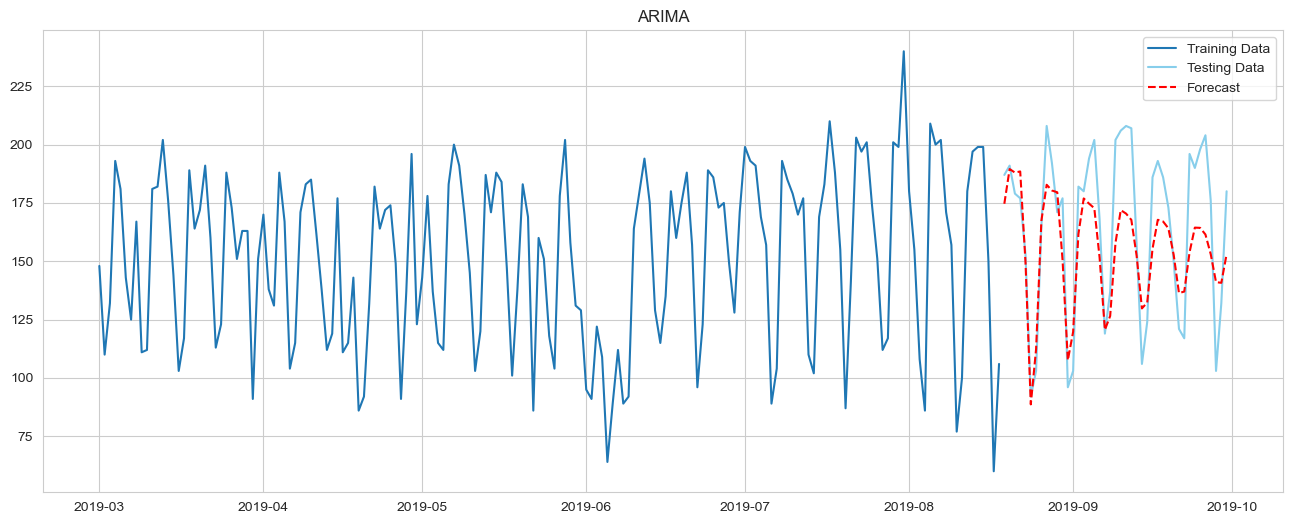

In [52]:
order_ar = (7,1,0)
model2 = ARIMA(train['Calls'], order=order_ar, enforce_stationarity=True)
arima_mod = model2.fit()
forecast_ar = arima_mod.forecast(steps=len(test))

plt.figure(figsize=(16, 6))
plt.title('ARIMA')
plt.plot(train.index, train['Calls'], label='Training Data')
plt.plot(test.index, test['Calls'], label='Testing Data', color='skyblue')
plt.plot(test.index, forecast_ar, label='Forecast', color='red', linestyle='--')
plt.legend()
plt.show()

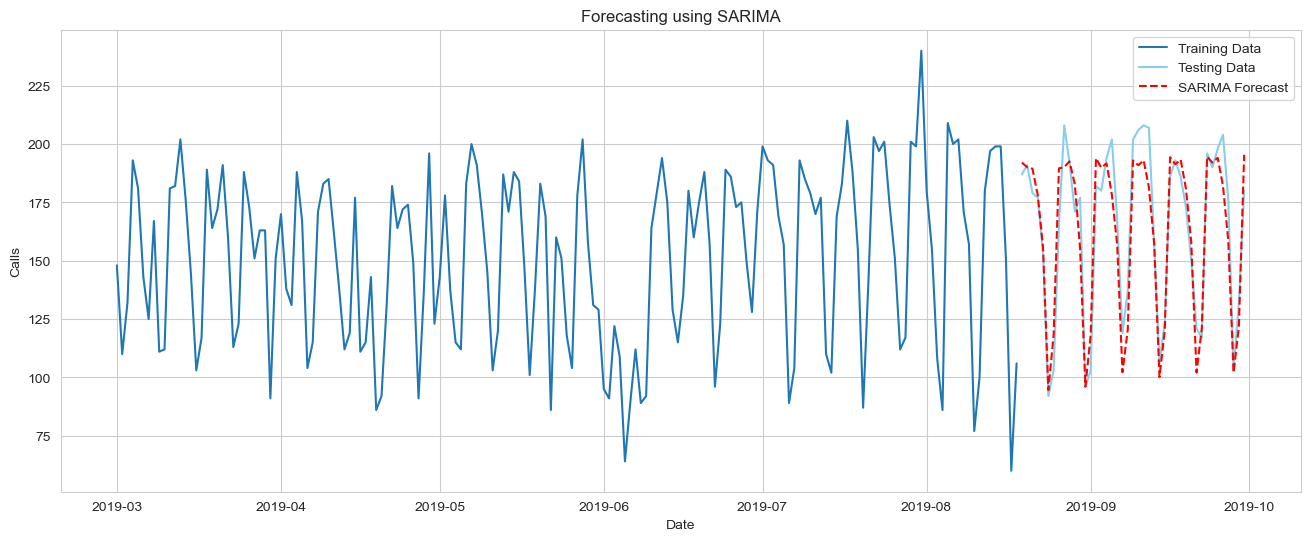

In [53]:
model3 = SARIMAX(train['Calls'], order=(2, 1, 1), seasonal_order=(1, 1, 3, 7))
sarima_model = model3.fit(disp=False)
forecast_sr = sarima_model.forecast(steps=len(test))

plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Calls'], label='Training Data')
plt.plot(test.index, test['Calls'], label='Testing Data', color='skyblue')
plt.plot(test.index, forecast_sr, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('Forecasting using SARIMA')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# a function to calculate the error statistics and performance of the model
def calc_error(test,forecast_sr):
    
    forecast_error = test.values.flatten() - forecast_sr
    mae = mean_absolute_error(test.values.flatten(), forecast_sr)
    rmse = np.sqrt(mean_squared_error(test.values.flatten(), forecast_sr))
    mape = np.mean(np.abs(forecast_error / test.values.flatten())) * 100
    smape = 100 * np.mean(2 * np.abs(test.values.flatten() - forecast_sr) / (np.abs(test.values.flatten()) + np.abs(forecast_sr)))
    bias = np.mean(forecast_error)

    return mae,rmse,mape,smape,bias

calc_error(test, forecast_sr)

(9.911659335111406,
 12.443632397146171,
 6.153957362345074,
 6.241202597736968,
 2.2749205903726226)

In [55]:
mae1,rmse1,mape1,smape1,bias1=calc_error(test,forecast_simp)
mae2,rmse2,mape2,smape2,bias2=calc_error(test,naive_pred)
mae3,rmse3,mape3,smape3,bias3=calc_error(test,forecast_exp)
mae4,rmse4,mape4,smape4,bias4=calc_error(test,forecast_ar)
mae5,rmse5,mape5,smape5,bias5=calc_error(test,forecast_sr)

In [56]:
train['day_of_year'] = train.index.dayofyear
train['day_of_week'] = train.index.dayofweek  # Extracting the day of the week (0 = Monday, 6 = Sunday) and day of the year
test['day_of_year'] = test.index.dayofyear
test['day_of_week'] = test.index.dayofweek  

In [57]:
xtrain = train[['day_of_year', 'day_of_week']]  # Using day of the year and day of the week as features
ytrain = train['Calls']
xtest = test[['day_of_year', 'day_of_week']]
ytest = test['Calls']


model_line = LinearRegression()
model_line.fit(xtrain, ytrain)
predictions_line = model_line.predict(xtest)

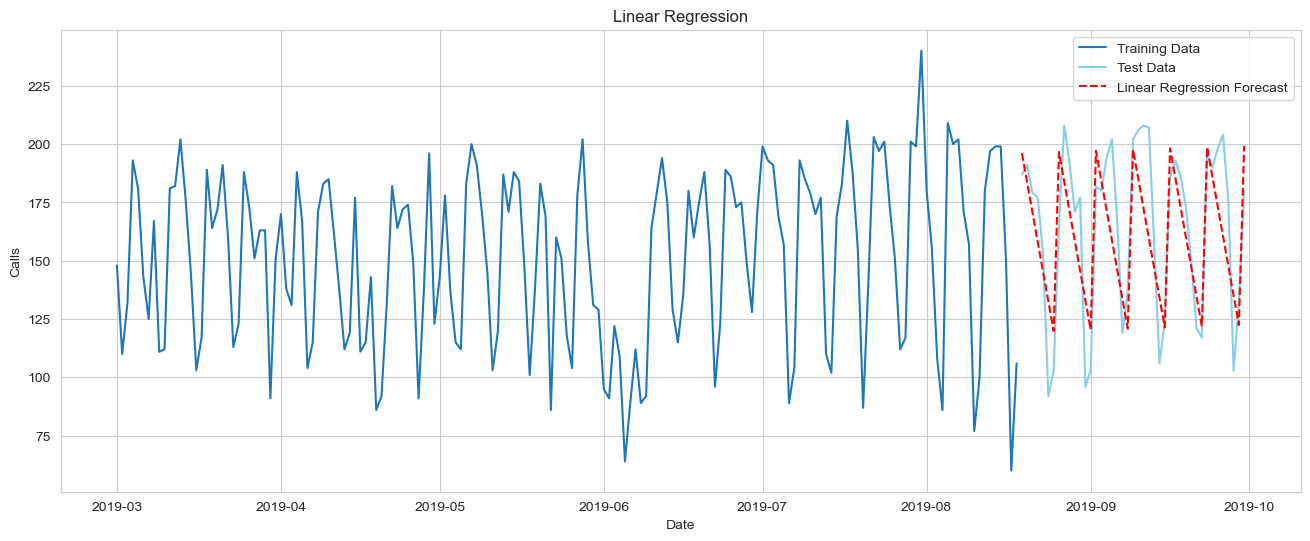

In [58]:
plt.figure(figsize=(16, 6))
plt.plot(train.index, ytrain, label='Training Data')
plt.plot(test.index, ytest, label='Test Data', color='skyblue')
plt.plot(test.index, predictions_line, label='Linear Regression Forecast', linestyle='--', color='red')
plt.title('Linear Regression')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
#only for Linear Regression
mae6 = mean_absolute_error(ytest, predictions_line)
rmse6 = np.sqrt(mean_squared_error(ytest, predictions_line))
mape6 = mean_absolute_percentage_error(ytest, predictions_line) * 100
smape6 = 2 * np.mean(np.abs(predictions_line - ytest) / (np.abs(predictions_line) + np.abs(ytest))) * 100
bias6 = np.mean(predictions_line - ytest)

In [60]:
eval_model1 = {
    'MAE': [mae1],
    'RMSE': [rmse1],
    'MAPE': [mape1],
    'SMAPE': [smape1],
    'Bias': [bias1] }

eval_model2 = {
    'MAE': [mae2],
    'RMSE': [rmse2],
    'MAPE': [mape2],
    'SMAPE': [smape2],
    'Bias': [bias2] }

eval_model3 = {
    'MAE': [mae3],
    'RMSE': [rmse3],
    'MAPE': [mape3],
    'SMAPE': [smape3],
    'Bias': [bias3] }

eval_model4 = {
    'MAE': [mae4],
    'RMSE': [rmse4],
    'MAPE': [mape4],
    'SMAPE': [smape4],
    'Bias': [bias4] }

eval_model5 = {
    'MAE': [mae5],
    'RMSE': [rmse5],
    'MAPE': [mape5],
    'SMAPE': [smape5],
    'Bias': [bias5] }

eval_model6 = {
    'MAE': [mae6],
    'RMSE': [rmse6],
    'MAPE': [mape6],
    'SMAPE': [smape6],
    'Bias': [bias6] }

df_metrics_model1 = pd.DataFrame(eval_model1, index=['Simple Exp'])
df_metrics_model2 = pd.DataFrame(eval_model2, index=['Naive'])
df_metrics_model3 = pd.DataFrame(eval_model3, index=['HWES'])
df_metrics_model4 = pd.DataFrame(eval_model4, index=['ARIMA'])
df_metrics_model5 = pd.DataFrame(eval_model5, index=['SARIMA'])
df_metrics_model6 = pd.DataFrame(eval_model6, index=['Linear Regression'])

df_metrics = pd.concat([df_metrics_model1, df_metrics_model2, df_metrics_model3, df_metrics_model4, df_metrics_model5,df_metrics_model6])

In [61]:
df_metrics = df_metrics.rename_axis('Models')
df_metrics

,MAE,RMSE,MAPE,SMAPE,Bias
Models,,,,,
Simple Exp,51.328748,58.462094,28.777717,34.263353,46.153051
Naive,60.441860,68.976403,33.367454,41.885518,58.906977
HWES,23.667660,27.137616,13.820409,15.082491,22.541079
ARIMA,18.781512,22.619674,11.306688,11.609757,10.049353
SARIMA,9.911659,12.443632,6.153957,6.241203,2.274921
Linear Regression,18.647217,22.304755,12.200044,12.010434,-4.719845


In [62]:
model = SARIMAX(new_df1['Calls'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
results = model.fit()
forecast = results.forecast(steps=60)

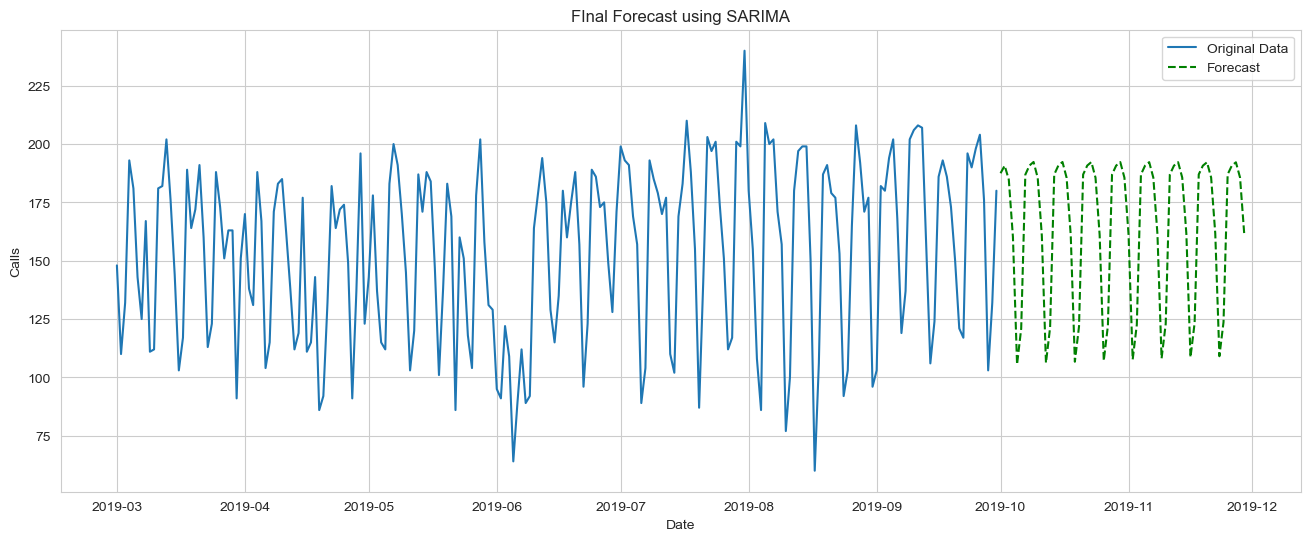

In [76]:
plt.figure(figsize=(16, 6))
plt.plot(new_df1.index, new_df1['Calls'], label='Original Data')
plt.plot(forecast.index, forecast.values, color='green', label='Forecast', linestyle='--')
plt.title('FInal Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
type(forecast)

pandas.core.series.Series

In [67]:
final_forecast = forecast.to_frame()

In [69]:
final_forecast = final_forecast.rename(columns={'predicted_mean': 'Forecasted Values'})

In [70]:
final_forecast.head()

,Forecasted Values
2019-10-01,187.493158
2019-10-02,190.746665
2019-10-03,184.758969
2019-10-04,160.187747
2019-10-05,105.565354


In [71]:
final_forecast = final_forecast.rename_axis('Dates')

In [79]:
final_forecast.reset_index(inplace=True)

In [81]:
final_forecast.to_csv("Forecasted Values.csv", index=False)